<a href="https://colab.research.google.com/github/RFdream/ML100-Days/blob/master/Data/Day087HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [0]:
import os
import keras
import itertools
from keras.layers import Input, Dense, BatchNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.optimizers import SGD,Adam,RMSprop

import matplotlib.pyplot as plt
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [0]:
train, test = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 32s 0us/step


In [0]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [0]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [0]:
def build_mlp():
    input_layer = Input(x_train.shape[1:])
    
    for i, n_units in enumerate([512, 256, 128]):
        layer = Dense(units=n_units, activation='relu', name='hidden_layer_' + str(i))
        x = layer(input_layer if i == 0 else x)
        x = BatchNormalization()(x)
        
    output_layer = Dense(units=10, activation='softmax', name='output_layer')(x)
    model = Model(inputs=[input_layer], outputs=[output_layer])
    return model

In [0]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 100
BATCH_SIZE = 512
MOMENTUM = 0.95

In [0]:
# 載入 Callbacks
def train(optimizer='adam'):
    results = {}
    
    for patience in [5, 10, 30]:
        for factor in [0.2, 0.5, 0.9]:
            name = 'p={}, f={}'.format(patience, factor)
            print(name)

            model = build_mlp()
            model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)

            reduce_lr = ReduceLROnPlateau(
                factor=factor, 
                min_lr=1e-12,
                monitor='val_loss', 
                patience=patience,
                verbose=1
            )

            results[name] =  model.fit(
                x_train,
                y_train,
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                validation_data=(x_test, y_test),
                shuffle=True,
                verbose=0
            )

    return results

In [0]:
# 繪製結果
def plot(results):
    fig, ax = plt.subplots(1, 2, figsize=(15, 10))
    
    for name, history in results.items():
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        acc = history.history['acc']
        val_acc = history.history['val_acc']
        
        ax[0].plot(loss, linestyle='-', label=name)
        ax[0].plot(val_loss, linestyle='--', label=name)
        ax[0].set_xlabel('loss')
        ax[0].set_ylabel('val_loss')
        ax[0].legend()
        
        ax[1].plot(acc, linestyle='-', label=name)
        ax[1].plot(val_acc, linestyle='--', label=name)
        ax[1].set_xlabel('acc')
        ax[1].set_ylabel('val_acc')
        ax[1].legend()
        
    plt.tight_layout()
    plt.show()

In [0]:
results_adam = train(optimizer=Adam(lr=LEARNING_RATE))

Instructions for updating:
Colocations handled automatically by placer.
p=5, f=0.2
Instructions for updating:
Use tf.cast instead.
p=5, f=0.5
p=5, f=0.9
p=10, f=0.2
p=10, f=0.5
p=10, f=0.9
p=30, f=0.2
p=30, f=0.5
p=30, f=0.9


Adam


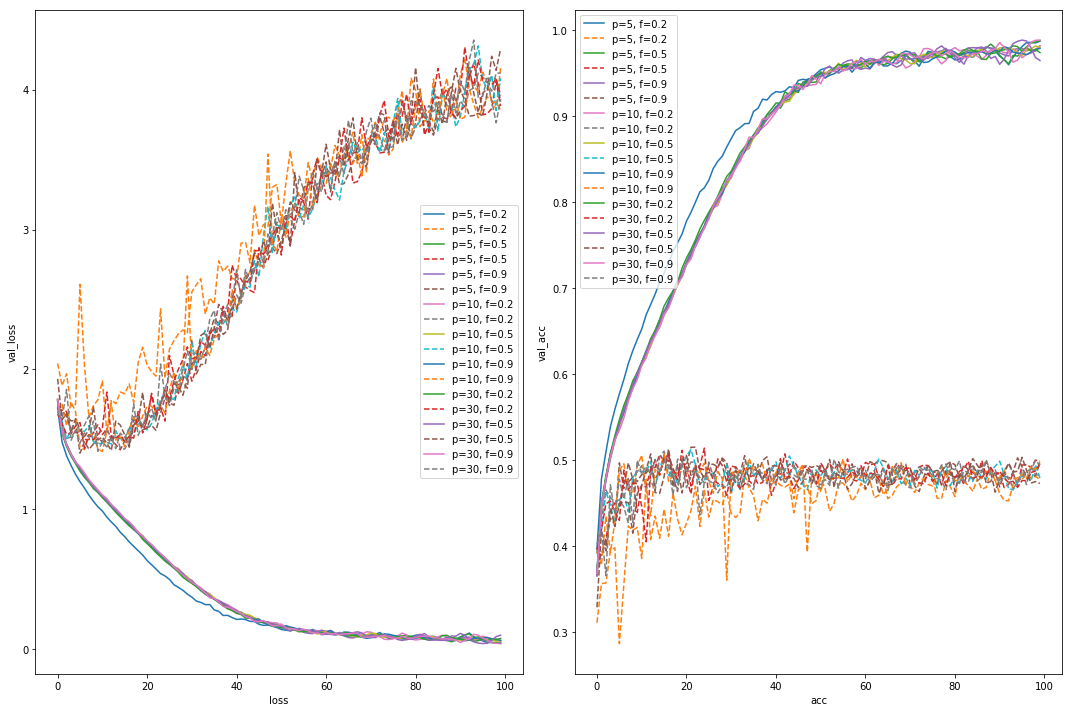

In [0]:
print('Adam')
plot(results_adam)

In [10]:
results_rmsprop = train(optimizer=RMSprop(lr=LEARNING_RATE))

Instructions for updating:
Colocations handled automatically by placer.
p=5, f=0.2
Instructions for updating:
Use tf.cast instead.
p=5, f=0.5
p=5, f=0.9
p=10, f=0.2
p=10, f=0.5
p=10, f=0.9
p=30, f=0.2
p=30, f=0.5
p=30, f=0.9


RMSprop


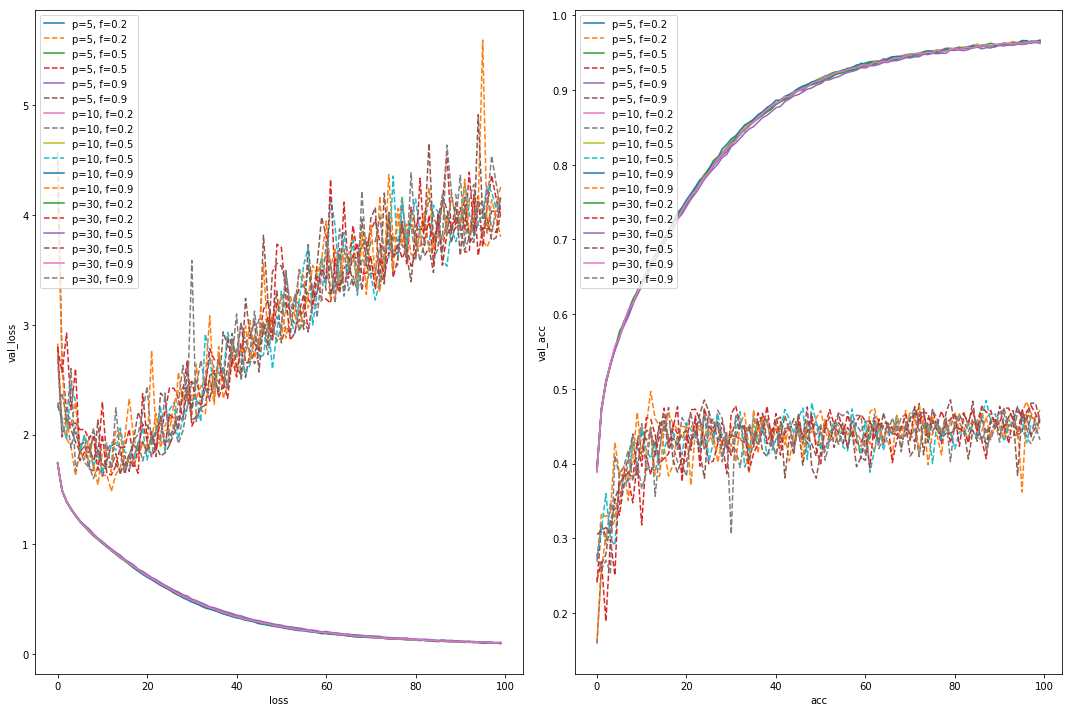

In [11]:
print('RMSprop')
plot(results_rmsprop)